## Install Libraries to be used
- !pip install -U pip setuptools wheel
- !pip install -U spacy
- !python -m spacy download en_core_web_sm
- !pip install emot --upgrade
- !pip install emoji --upgrade
- !pip install spacymoji
- !pip install spacytextblob
- !pip install wordcloud

## Importing Libraries that will be used

In [1]:
# General Dependencies
import ast
import json
import random 
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import os
from timeit import default_timer as timer
from tqdm.notebook import tqdm
tqdm.pandas()

# Load the fields list
import fields
fieldsFilter = fields.fields

# Wordcloud Dependencies
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Emoji Dependencies
import unicodedata
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emoji



## Initialize the NLP Module

In [2]:
# Declare Spacy NLP Module
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

## Initialize the Functions

In [3]:
def createDataSample(datafile = "",sample_count = 0):
    
    '''
        Creates a sample dataset from a given json file
        @param {'type':string} datafile - file path of the twitter json file
        @param {'type':string} sample_count - Number of samples to create
        
    '''
    
    list_tweets = None
    
    with open(datafile, "r") as myfile:        
        list_tweets = list(myfile)

    if int(sample_count) > len(list_tweets):
        sample_count = len(list_tweets)

    sample = random.sample(list_tweets, int(sample_count))
    
    file = open("./tweets/sample_"+str(sample_count)+".json", "w")
    for i in sample:
        file.write(i)
    file.close() #This close() is important

    return print("Sample File Created.")


# CLEANING  FUNCTIONS

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_urls(text):
    result = re.sub(r"http\S+", "", text)
    return(result)

def remove_twitter_urls(text):
    clean = re.sub(r"pic.twitter\S+", "",text)
    return(clean)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def remove_user_mentions(text):
    clean_tweet = re.sub("@[A-Za-z0-9_]+","", text)
    clean_tweet = re.sub("#[A-Za-z0-9_]+","", clean_tweet)
    return clean_tweet

def change_to_lowercase(text):
    return text.lower()    

def remove_returnchar(text):
    clean_tweet = text.replace('\r','')
    return clean_tweet

def remove_whitespaces(text):
    clean_tweet = text.replace(r'(\r\n)+|\r+|\n+|\t+','')
    return clean_tweet
    
def extractTweetText(datfile):
    
    #Initialize Temporary Array Storage
    tempStorage = []

    #Parse Json to a temporary storage
    with open('./tweets/'+datfile, 'r') as f:
        for line in f:
            tempStorage.append(json.loads(line))

    # Convert Array to a Pandas Data Frame
    tempFrame = pd.DataFrame(tempStorage)
    
    # Drop all columns except for text column
    tempFrame = tempFrame[['text']]
    
    #Get only the file name and remove the extension
    fname = str(datfile).split('.')[0]
    
    #Save dataframe to csv
    tempFrame.to_csv(r'./step_1/s1_'+str(fname)+'.csv')

# Clean and process tweet text by removing URL, EMOJI and User Mentions
def removeTwitterMeta(datfile):    
    tweet_df = pd.read_csv('./step_1/'+str(datfile),index_col=False) 
    #Replace the spaces and enters
    tweet_df = tweet_df.loc[:, tweet_df.columns.isin(fieldsFilter)]
    print("Step 1 : Cleaning Whitespaces")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_whitespaces(x))
    print("Step 2 : Cleaning URLs")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_urls(x))
    print("Step 3 : Cleaning Twitter URLs")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_twitter_urls(x))
    print("Step 4 : Converting Emoji To Words")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : emoji_to_word(x))
    print("Step 5 : Cleaning Emoticons")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_emoticons(x))
    print("Step 6 : Cleaning Twitter User Mentions")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : remove_user_mentions(x))
    print("Step 6 : Converting To Lower Case")
    tweet_df['text'] = tweet_df['text'].progress_apply(lambda x : change_to_lowercase(x))

    #Get only the file name and remove the extension
    fname = str(datfile).split('_')[1]
    fname = str(fname).split('.')[0]
    tweet_df.to_csv(r'./step_2/s2_'+str(fname)+'.csv')

def defineVocabulary(data):
    tempStorage = []
    with nlp.select_pipes(disable=["parser", "lemmatizer","spacytextblob",]):
        doc= nlp(data)
        for token in doc:
            tempStorage.append({token.text,token.pos_})
    return tempStorage

def removeStopWords(data):    
    tempStorage = ast.literal_eval(data)    
    # Load stop words
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    # Loop inside text
    for x in tempStorage:
        if x in spacy_stopwords: tempStorage.remove(x) 
    return tempStorage

def definePolarization(data):   
    with nlp.select_pipes(disable=["tok2vec", "parser", "attribute_ruler", "lemmatizer"]):
        doc= nlp(data)
    return doc._.polarity

def defineSubjectivity(data):
    with nlp.select_pipes(disable=["tok2vec", "parser", "attribute_ruler", "lemmatizer"]):
        doc= nlp(data)
    return doc._.subjectivity

def defineAssessments(data):
    with nlp.select_pipes(disable=["tok2vec", "parser", "attribute_ruler", "lemmatizer"]):
        doc= nlp(data)
    return doc._.assessments
    
def emoji_to_word(text):
    return emoji.demojize(text, delimiters=("", ""))

# Tokenize the text in the dataframe
def tokenizeText(data):
    tempStorage = []
    with nlp.select_pipes(disable=["tagger", "parser", "lemmatizer"]):
        doc = nlp(data)
        for word in doc:
            tempStorage.append(word.text)
    return tempStorage

def generateWordcloudData(payload):    
    """
      This Function Accepts a pandas dataframe from any step of the processing with the named text column.
      payload - pandas dataframe with string text column.
    """   
    
    combinedText = ""
    
    textData = payload['text']
    textData = pd.DataFrame(textData)
    
    combinedText = combinedText.join(textData.text)

    #image storage
    # https://drive.google.com/file/d/14DRvgevx-ffa9BKPztzt3nE9B2TamWhJ/view?usp=sharing
    mask = np.array(Image.open("./img/cov19.png")) #jpg also ok
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(
                            max_font_size = 140,
                            width = 2000,
                            height = 1000,
                            background_color = "white",
                            mask=mask,
                            contour_width = 1,
                            stopwords = STOPWORDS)

    wordcloud.generate(combinedText)

    plt.imshow(wordcloud)#, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
#     plt.imshow(mask)#, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
#     plt.show()
    #write to img
    image = wordcloud.to_image()
    image.show()    
    
    return plt.show()

In [4]:
def generateUniqueWords(data):

    no_top_unique_words = "50" #@param {type:"string"}

    result = Counter(" ".join(tweet_df['text'].values.tolist()).split(" ")).items()
    df2 = pd.DataFrame(result)
    df2.columns =['Word', 'Frequency']
    df2 = df2[df2.Word != ""] #Deletes the empty spaces counted
    df2 = df2.sort_values(['Frequency'], ascending=[False]) #Sort dataframe by frequency (Descending)

    print('\033[1mTop '+no_top_unique_words+' most unique words used from the dataset\033[0m \n')
    print(df2.head(int(no_top_unique_words)).to_string(index=False)) #Prints the top N unique words used
    print("\n")
    df3 = df2.head(int(no_top_unique_words))
    df3.plot(y='Frequency', kind='pie', labels=df3['Word'], figsize=(9, 9), autopct='%1.1f%%', title='Top '+no_top_unique_words+' most unique words used from the dataset')

In [ ]:
# Create A Sample Dataset to process
# createDataSample(datafile =  './complete/20200730.json', sample_count = 100)

In [5]:
# Step 0
# Specify Raw Tweet Directory
tweetDir = './tweets'
_, _, filenames = next(os.walk(tweetDir))

for file in filenames:
    extractTweetText(file)

In [6]:
# Step 1
#Extract Text of Tweets and Save to CSV file

tweetDirS1 = './step_1'
_, _, filenames_s1 = next(os.walk(tweetDirS1))

for file in filenames_s1:
    start = timer()
    removeTwitterMeta(file)
    end = timer()
    print(end - start)

Step 1 : Cleaning Whitespaces


  0%|          | 0/283677 [00:00<?, ?it/s]

Step 2 : Cleaning URLs


  0%|          | 0/283677 [00:00<?, ?it/s]

Step 3 : Cleaning Twitter URLs


  0%|          | 0/283677 [00:00<?, ?it/s]

Step 4 : Converting Emoji To Words


  0%|          | 0/283677 [00:00<?, ?it/s]

Step 5 : Cleaning Emoticons


  0%|          | 0/283677 [00:00<?, ?it/s]

Step 6 : Cleaning Twitter User Mentions


  0%|          | 0/283677 [00:00<?, ?it/s]

Step 6 : Converting To Lower Case


  0%|          | 0/283677 [00:00<?, ?it/s]

125.68810690000001


In [7]:
# Step 2
# Get The Files inside the step_2 folder for futher processing
tweetDirS2 = './step_2'
_, _, filenames_s2 = next(os.walk(tweetDirS2))

for file in filenames_s2:
    start = timer()    
    mydata = pd.read_csv('./step_2/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    mydata['ttext'] = mydata['text'].progress_apply(lambda x : tokenizeText(x))
    
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_3/s3_'+str(fname)+'.csv')
    end = timer()
    print(end - start)


  0%|          | 0/283677 [00:00<?, ?it/s]

1263.2740231


In [8]:
# Step 3
# Get The Files inside the step_3 folder and reduce the connecting words
tweetDirS3 = './step_3'
_, _, filenames_s3 = next(os.walk(tweetDirS3))

for file in filenames_s3:
    start = timer()
    mydata = pd.read_csv('./step_3/'+file,index_col=False)
    del mydata['Unnamed: 0']
    mydata['nstop'] = mydata['ttext'].progress_apply(lambda x : removeStopWords(x))
    
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_4/s4_'+str(fname)+'.csv')
    end = timer()
    print(end - start)

  0%|          | 0/283677 [00:00<?, ?it/s]

13.068637999999964


In [9]:
# Step 4
# Get The Files inside the step_5 folder add column for polarity, assessment and subjectivity

tweetDirS4 = './step_4'
_, _, filenames_s4 = next(os.walk(tweetDirS4))

for file in filenames_s4:
    start = timer()
    mydata = pd.read_csv('./step_4/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    print("Processing Text Polarization")
    mydata['polarization'] = mydata['text'].progress_apply(lambda x : definePolarization(x))
    print("Processing Text Subjectivity")
    mydata['subjectivity'] = mydata['text'].progress_apply(lambda x : defineSubjectivity(x))
    print("Processing Text Assessments")
    mydata['assessment'] = mydata['text'].progress_apply(lambda x : defineAssessments(x))
    
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_5/s5_'+str(fname)+'.csv')
    end = timer()
    print(end - start)
# Seperate wordscore in 3 seperate columns
mydata

Processing Text Polarization


  0%|          | 0/283677 [00:00<?, ?it/s]

Processing Text Subjectivity


  0%|          | 0/283677 [00:00<?, ?it/s]

Processing Text Assessments


  0%|          | 0/283677 [00:00<?, ?it/s]

2205.823334


,text,ttext,nstop,polarization,subjectivity,assessment
0,"by this weekend it’s likely that 200,000 peopl...","['by', 'this', 'weekend', 'it', '’s', 'likely'...","['this', 'weekend', '’s', 'likely', '200,000',...",0.000000,1.000000,"[([likely], 0.0, 1.0, None)]"
1,how does he not understand the difference bet...,"[' ', 'how', 'does', 'he', 'not', 'understand'...","[' ', 'does', 'not', 'understand', 'difference...",-0.086364,0.572727,"[([positive], 0.22727272727272727, 0.545454545..."
2,parliament live updates: debate on covid-19 in...,"['parliament', 'live', 'updates', ':', 'debate...","['parliament', 'live', 'updates', ':', 'debate...",0.136364,0.500000,"[([live], 0.13636363636363635, 0.5, None)]"
3,mesa public schools &amp; city team up to give...,"['mesa', 'public', 'schools', '&', 'amp', ';',...","['mesa', 'public', 'schools', '&', 'amp', ';',...",0.200000,0.433333,"[([public], 0.0, 0.06666666666666667, None), (..."
4,"maybe he really meant ""herd mentality"", becau...","[' ', 'maybe', 'he', 'really', 'meant', '""', '...","[' ', 'maybe', 'really', 'meant', '""', 'herd',...",0.200000,0.200000,"[([really], 0.2, 0.2, None)]"
...,...,...,...,...,...,...
283672,…,"[' ', '…']","[' ', '…']",0.000000,0.000000,[]
283673,"check this out, nashville's mayor is busted ...","[' ', 'check', 'this', 'out', ',', 'nashville...","[' ', 'check', 'out', ',', 'nashville', 'mayo...",0.000000,0.300000,"[([low], 0.0, 0.3, None)]"
283674,yelp just lost 60% of their addressable market...,"['yelp', 'just', 'lost', '60', '%', 'of', 'the...","['yelp', 'lost', '60', '%', 'their', 'addressa...",0.000000,0.000000,[]
283675,the new trump wh covid-19 plan! \n\nwtf?,"['the', 'new', 'trump', 'wh', 'covid-19', 'pla...","['new', 'trump', 'wh', 'covid-19', 'plan', '!'...",-0.164773,0.727273,"[([new, !], 0.17045454545454544, 0.45454545454..."


In [10]:
# Step 5 OPTIONAL
# Get The Files inside the step_4 folder check

tweetDirS5 = './step_5'
_, _, filenames_s5 = next(os.walk(tweetDirS5))

for file in filenames_s5:
    start = timer()
    mydata = pd.read_csv('./step_5/'+file,index_col=False)
    del mydata['Unnamed: 0'] 
    processingFrame = mydata['text'].copy()
    processingFrame = pd.DataFrame(processingFrame)
    processingFrame['wordDef'] = processingFrame['text'].progress_apply(lambda x : defineVocabulary(x))
    mydata['wordDef'] = processingFrame['wordDef'].copy()
    #Get only the file name and remove the extension
    fname = str(file).split('_')[1]
    fname = str(fname).split('.')[0]
    mydata.to_csv(r'./step_6/s6_'+str(fname)+'.csv')
    end = timer()
    print(end - start)

  0%|          | 0/283677 [00:00<?, ?it/s]

1178.5139718999994


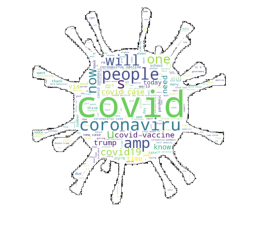

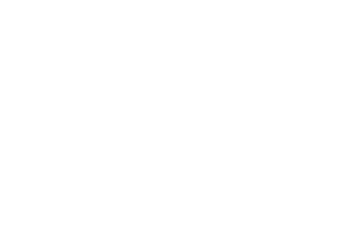

In [11]:
generateWordcloudData(mydata)